# Homework 1, NLP Spring 2021

## Due Feb 26, 2021 at 11:59pm China Time

Name: Xinyao Han

NetID: xh1082

Please submit the following items to the Gradescope:
* Your Colab notebook link (by clicking the Share button at the top-right corner of the Colab notebook, share to anyone).
* The printout of your run in Colab notebook in pdf format

Note:
* No late submission is permitted.
* All solutions must be from your own work.
* Total points of the assignment is 100.

# Setup environment

In [ ]:
!pip install nltk datasets

     |████████████████████████████████| 184kB 5.6MB/s 
     |████████████████████████████████| 245kB 6.6MB/s 
     |████████████████████████████████| 112kB 9.6MB/s 
     |████████████████████████████████| 20.7MB 1.6MB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


# 1. Maximum Likelihood Estimation of Bigram LM [5 pts]

You are given a training set of sentences $\{W_i\}$ where i=1...M. The i-th sentence is $W_i = w_1w_2...w_{N_i}$. 
We want to estimate a bigram LM using the training set.

Write down the log likelihood of the training set, and then show mathematically that the MLE solution of a bigram LM $\hat{P}(v|u)$ =
$\frac{C(u,v)}{C(u)}$ where C(u,v) is bigram count, and C(u) is unigram count.
We assume the vocabulary size is $V$.

Solution:
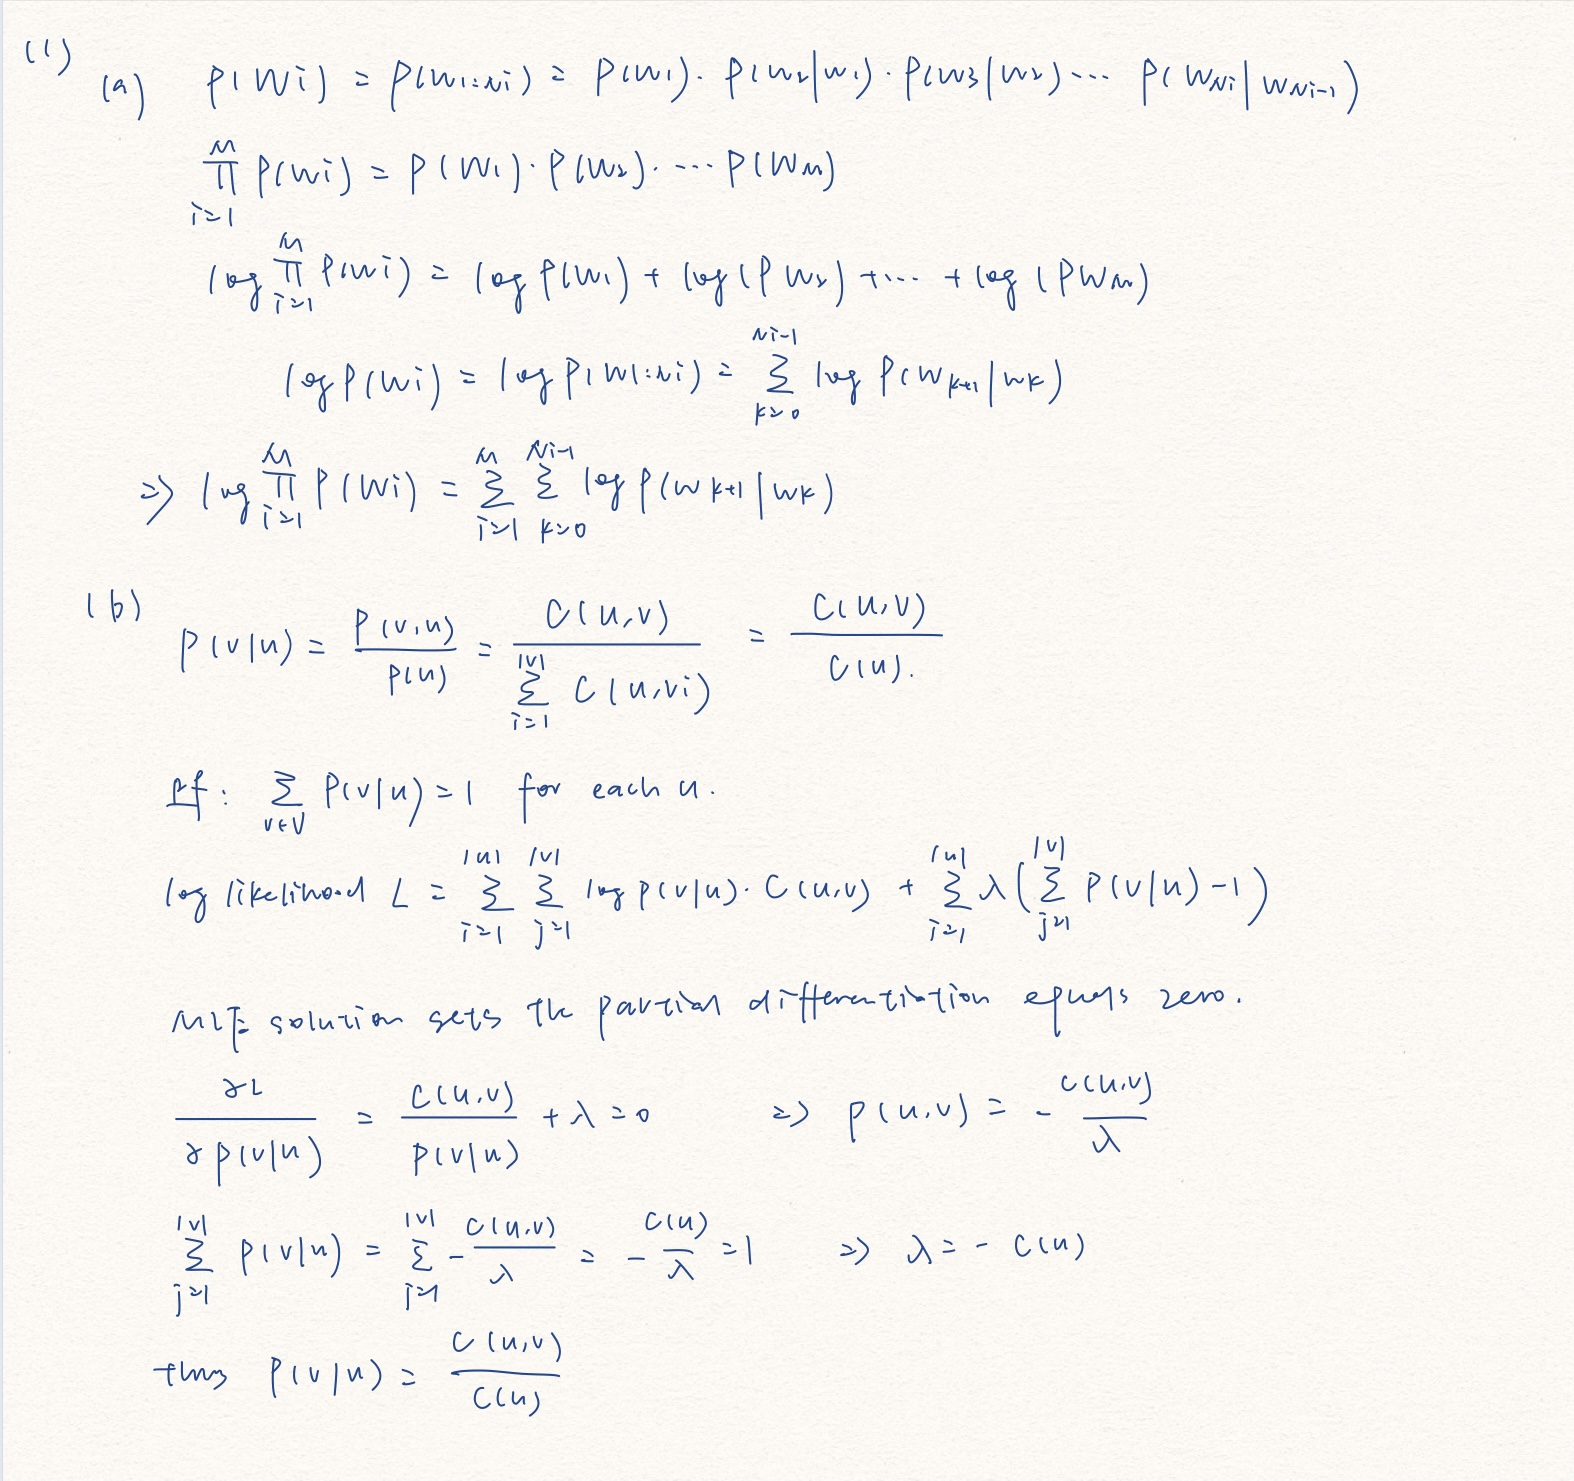

# 2. Backoff N-gram LM with Kneser-Ney smoothing [55 pts]

Kneser-Ney smoothing is a method of modifying the N-gram counts. The modified counts at N-gram order i (i.e. the continuation counts) are derived from the order i+1 counts. Absolute discounting is applied to estimate probability distributions. Backoff weights are computed so that summation of probability given *any* word context should sum to 1.0.

We may refer to the backoff N-gram LM in lecture slide 27, and lecture slide 32 for how to calculate the modified N-gram counts to estimate the lower-order $P_{continuation}(w)$.

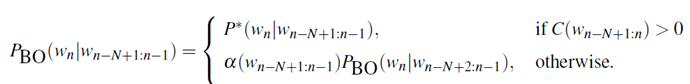

where $P^*(w_n|w_{n-N+1:n-1}) = \frac{\max\{C(w_{n-N+1:n-1},w_n)-D, 0\}}{C(w_{n-N+1:n-1})}$. $P^*(.)$ is the absolute discounted N-gram probability distribution.

In this assignment, we assume that backing off to a unigram LM $P_{BO}(w)$ ends the recursive probability computation.

##__a__. When a word context is unseen (i.e not occurred in the training data), what is the backoff weight, i.e. $\alpha(context)$.  [5 pts]

Solution:
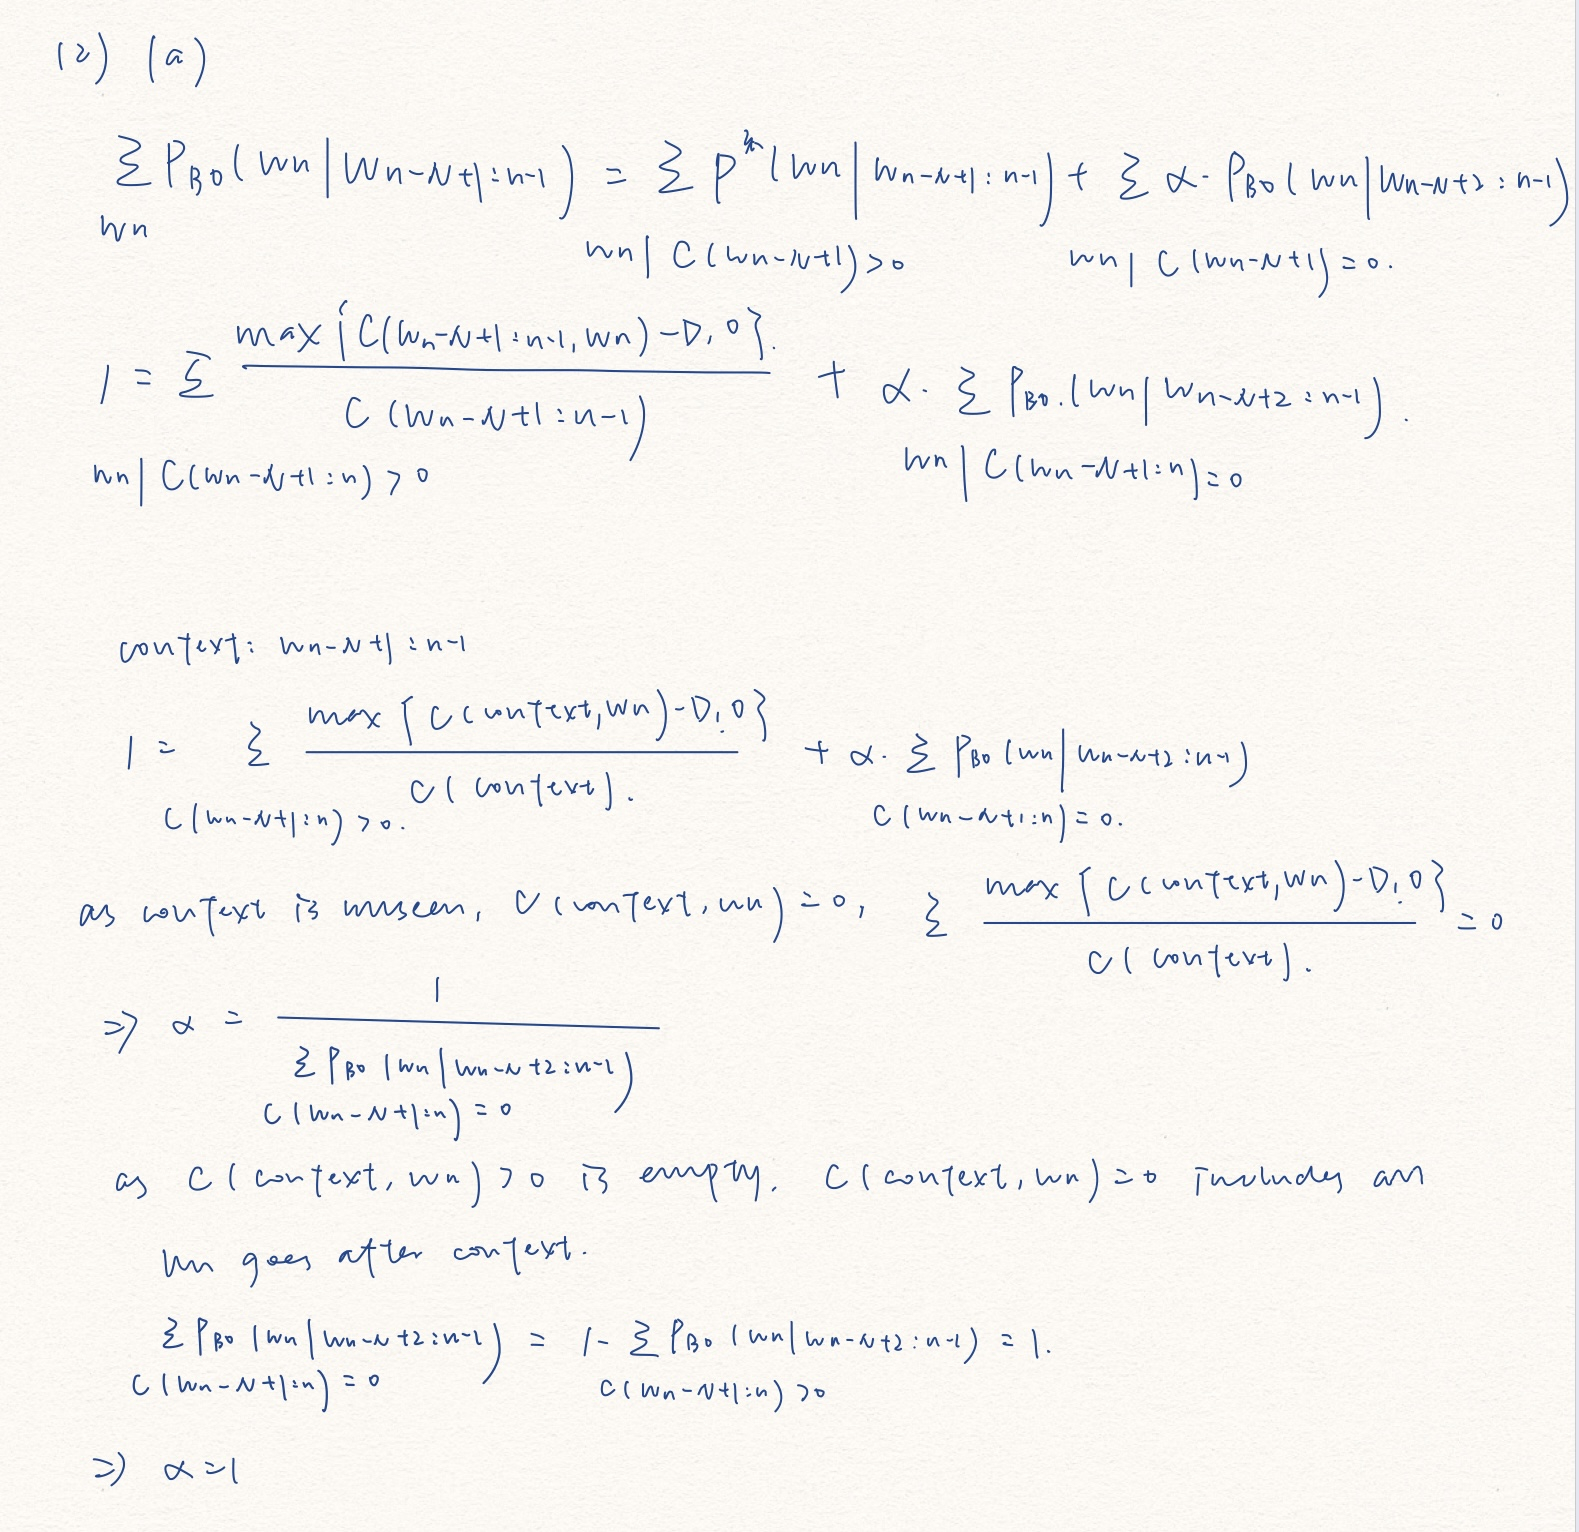


##__b__. Implement `class KNLM`. [40 pts]

In this question, you will implement a backoff Kneser-Ney LM.

The backoff Kneser-Ney LM `class KNLM` support the following functions:
* Select the top-K vocabulary based on the `min_count` on the training data. If `min_count` is 1, all vocabulary will be selected from the training data.
* Calculate raw N-gram counts from a dataset.
* Calculate all lower-order modified N-gram counts based on Kneser-Ney smoothing.
* Estimate LM model parameters: discounted probability distributions and backoff weights for each N-gram order.
* Calculate word perplexity on a dataset.
* Generate a random sentence using the LM.

All word tokens that are not in the selected vocabulary should be mapped to `<unk>`, the unknown word token.

### Dataset
We use the datasets module from Huggingface to load the Penntree bank text data for LM experiment. Example of getting an iterable over sentences is shown in `class KNLM`.

### Limited usage of NLTK
We allow using `nltk.ngrams` to compute the ngrams given a list of word tokens. But you are NOT allowed to use any other functions and data structures in nltk for this assignment.

### Data structure
You may use the provided data structure to complete the task. We assume using the Python dictionaries to store the discounted probs and backoff weights, as provided in `class KNLM`.

Context: A tuple of strings

word: A string

order 1: unigram, order 2: bigram and so forth.

For example:

`self._prob[1][context=()][word="is"]` stores the absolute discounted probs P*("is") for unigram (N-gram order = 1).

`self._prob[2][context=("this",)][word="is"]` stores the absolute discounted probs P*("is"|"this") for bigrams (N-gram order = 2).

`self._bow[2][context=("this",)]` stores the backoff weight for the word context at N-gram order = 2.

`self._prob[3][context=("this","is",)][word="a"]` stores the absolute discounted probs P*("a"|"this is") for trigrams (N-gram order = 3).

`self._bow[3][context=("this", "is",)]` stores the backoff weight for the word context at N-gram order = 3.

We also provide a data structure to store the N-gram counts in `self.counters`.

Alternatively, you may also use other Python data structure as you see fit to store the LM parameters.

### Correctness
All the estimated probabilities of *any* context must sum to 1.0. You may use `def check_lm()` and `def check_prob()` to check the correctness by trying out some word context at different N-gram orders. You should carefully check the validity of your LM.

In [ ]:
import datasets
from datasets import load_dataset
import nltk
nltk.download('punkt')
from collections import defaultdict
import math
import random

class SimpleTokenizer:
  def __init__(self):
    pass

  def tokenize(self, sentence):
    return sentence.strip().split()

class KNLM:
  def __init__(self, order, D, min_count, tokenizer):
    """
    order: integer. order = 1...N
    D: Absolute discounting factor 0 < D < 1
    min_count: at least 1
    tokenizer: tokenize a given sentence string
    """
    self._bos = "<s>"
    self._eos = "</s>"
    self._unk = "<unk>"

    # set class variables
    self._order = order
    self._D = D
    self._min_count = min_count
    self._tokenizer = tokenizer

    # data structures for the LM
    # probs
    self._prob = [defaultdict(lambda: defaultdict(float)) for i in range(order+1)]

    # backoff weights alpha(context)
    self._bow = [defaultdict(float) for i in range(order+1)]

    # vocabulary set
    self._vocab = set()

    # DS to store the N-gram counts
    self._counters = [defaultdict(lambda: defaultdict(int)) for i in range(order+1)]

  def print_counter(self, counter):
    """
    Debugging purpose: You may want to print the counters based on only a handful of sentences 
    and see if the computed counts are equal to the ones computed by hand.
    """
    for context in counter.keys():
      for word in counter[context].keys():
        print("{} {} {}".format(context, word, counter[context][word]))

  def _select_vocab(self, dataset, min_count):
    """
    Select vocabulary when the word count is >= min_count
    """
    counter = defaultdict(int)
    for sample in dataset:
      tokens = self._tokenizer.tokenize(sample['sentence'])

    # TODO: Your code
      for i in tokens:
        counter[i] = counter.get(i,0)+1

    for word in counter:
      if counter[word] >= min_count:
        self._vocab.add(word)

    self._vocab.add(self._bos)
    self._vocab.add(self._eos)
    self._vocab.add(self._unk)

    print("Size of vocabulary is {}".format(len(self._vocab)))
    


  def compute_count(self, dataset, order):
    """
    dataset: iterable yielding a dictionary object that has a field 'sentence'
    order: integer. order = 1...N
    counter is just a dictionary of a dictionary of a integer
    counter[context][word] stores the raw N-gram counts
    """
    counter = defaultdict(lambda: defaultdict(int))
    for sample in dataset:
      tokens = self._tokenizer.tokenize(sample['sentence'])

      # map word not in vocab to <unk>
      # TODO: Your code

      #tokens = list(tokens)
      for i in range(len(tokens)):
        if tokens[i] not in self._vocab:
          tokens[i] = self._unk

      # a generator of N-gram tuples

      text_ngrams = nltk.ngrams(tokens, n=order, pad_left=True, pad_right=True, left_pad_symbol=self._bos, right_pad_symbol=self._eos) 

      for i in text_ngrams:
        c = i[:-1]
        w = i[-1]
        counter[c][w] = counter[c].get(w,0)+1
      
    return counter

  def compute_prob(self, context, word, order):
    """
    Calculate the smoothed P(word|context) at N=order 
    context: tuple of strings
    word: string
    order: integer. order = 1...N

    """
    p = 0.0
    # TODO: Your code
    # using self._counter fail to update p, with p 0.0 for all w, original function
    """
    counter = self._counters[order]                     # base case
    
    if order == 1:
      prob = self.estimate_prob(counter, self._D, 1)
      p = prob[context][word]
    return p

    if context in counter.keys():                      # p*
      if word in counter[context].keys():
        prob = self.estimate_prob(counter, self._D, order)
        p = prob[context][word]
    else:                                   # P_BO
      alpha = self._bow[order][context]
      p_bo = self.compute_prob(list(context)[1:],word,order-1)
      p = alpha * p_bo

    return p
    """
    # new using prob
    if word not in self._vocab:
      word = self._unk

    prob = self._prob[order][context][word]
    
    if order == 1:                             # base case
      return prob

    if prob > 0:                              # p*
      p = prob
    else:                                   # P_BO
      alpha = self._bow[order][context]
      p_bo = self.compute_prob(context[1:],word,order-1)
      if alpha > 0:
        p = alpha * p_bo
      else:
        p = p_bo    
    return p



  
  def estimate_backoff_weight(self, order):
    """
    Compute the backoff weight for an input order.
    order: 2...N
    self._bow[order] should be updated after calling the function.
    """
    # TODO: Your code
    """ # original
    counter = self._counters[order]
    prob = self.estimate_prob(counter,self._D,order)

    lo_counter = self.compute_lo_count(counter)
    lo_prob = self.estimate_prob(lo_counter,self._D,order-1)
    
    for context, word in counter.items():
      sum_p1 = sum(prob[context].values())
      sum_p2 = sum(lo_prob[context[1:]].values())
      alpha = (1-sum_p1)/(1-sum_p2)
      self._bow[order][context] = alpha
    """      
    #pass
    # prob: 1 - sum(seen)
    # lo_prob: 1 - sum(lo_seen)
    """
    for context in self._prob[order].keys():
      sum_prob = sum(self._prob[order][context].values())
      sum_lo_prob = sum(self._prob[order-1][context[1:]].values())
      alpha = (1-sum_prob)/(1-sum_lo_prob)
      self._bow[order][context] = alpha  
    """
    
    for context, word in self._prob[order].items():
      n = 1
      d = 1
      for i in word.keys():
        n -= self._prob[order][context][i]
        d -= self._prob[order-1][context[1:]][i]
      self._bow[order][context] = n/d
      

  def compute_lo_count(self, counter):
    """
    Given a counter object that stores the N-gram counts,
    return the N-1 gram counter calculated from Kneser-Ney smoothing.
    """
    lo_counter = defaultdict(lambda: defaultdict(int))


    # TODO: Your code
    # pass

    for context, word in counter.items():
      number_count = len(word)
      lo_context = context[1:]
      for lo_word in word.keys():
        lo_counter[lo_context][lo_word] = lo_counter[lo_context].get(lo_word,0) + 1
    return lo_counter


  def estimate_prob(self, counter, D, order):
    """
    Compute the discounted probabilities using absolute discounting, 
    using the input counter, with discount factor D, and the order.
    """
    # prob[context][word] returns a score
    prob = defaultdict(lambda: defaultdict(float))  
    # TODO: Your code
    for context, word in counter.items():
      for i in word:
        if i == self._bos:
          continue
        if counter[context][i] > 0:  
          if order == 1: #unigram
            word_count = counter[context][i]
            p = word_count/sum(word.values())
            prob[tuple(context)][i] = p
          else:
            word_count = counter[context][i]
            p = max(word_count-D,0)/sum(word.values())
            prob[tuple(context)][i] = p

    return prob

  def train(self, dataset):
    """
    Train a backoff N-gram language model with Kneser-Ney smoothing.
    dataset: an iterable object
    """
    # select vocab by taking the top-K
    print("estimating vocabulary set with mincount = {}".format(self._min_count))
    self._select_vocab(dataset, self._min_count)

    # compute the raw count of the highest N-order
    print("Compute raw count for order {}".format(self._order))
    self._counters[self._order] = self.compute_count(dataset, self._order)

    # Your Code: Use the member functions to complete the training steps
    # Hint: You may compute the modified counts for all N-gram orders first.
    #                
    # Then compute all backoff weights at the final step.
    for i in range(self._order-1,0,-1):
      self._counters[i] = self.compute_lo_count(self._counters[i+1])
    #print('counter',self._counters[2])
    for i in range(1, self._order+1):
      self._prob[i] = self.estimate_prob(self._counters[i], self._D, i)
    #print('prob',self._prob[2])
    for i in range(2,self._order+1):
      self.estimate_backoff_weight(i)

    #print('bow',self._bow[4])


  def perplexity(self, dataset):
    """
    Compute word perplexity of a dataset.
    dataset: an iterable object
    """
    # Your Code
    log_prob = 0.0
    N = 0.0
    for sample in dataset:
      tokens = self._tokenizer.tokenize(sample['sentence'])

      # Your Code
      # use self.compute_prob(.) to calculate the probabilities
      tokens = tuple([self._bos] + tokens + [self._eos])

      for i in range(1,len(tokens)):
        if i < self._order-1:
          log_prob += math.log(self.compute_prob(tokens[:i], tokens[i], i+1))
        else:
          log_prob += math.log(self.compute_prob(tokens[i-self._order+1:i],tokens[i],self._order))
      N = N + len(tokens)

    return math.exp(-log_prob/N)

  def generate(self):
    """
    Generate a random sentence using the trained LM.
    Return a sentence.
    """

    context = [self._bos] * (self._order-1)
    result = []

    # Your Code
    # randomly generate

  #  word = random.choices([self._counter[self._order][context].keys() for i in range(1,self._order+1))
  #  result.append(word)
  #  context = context[1:] + word
    """
    while True:
      p = random.random()
      for word in self._vocab:
        if word in [self._bos, self._unk]:
          continue
        p += self.compute_prob(tuple(context[-(self._order-1):]), word, self._order)
        if p >= 1.0:
          break
        if word == self._eos:
          break
        context.append(word)
        result.append(word)
      
    return " ".join(result)
    
    """
    result.append(self._bos)
    while result[-1] != self._eos:
      prob = []
      n = random.random()
      total = 0
      for word in list(self._vocab):
        if word != self._bos and word != self._unk:
          c = tuple(context)
          p = self.compute_prob(c, word, self._order)
          prob.append((p, word))

      for probability in sorted(prob, reverse = True):
        total += probability[0]
        if total > n:
          context = context[1:] + [probability[1]]
          result.append(probability[1])
          break

    result.remove(self._bos)
    result.remove(self._eos)
    return " ".join(result)

  def check_prob(self, context, order):
    z = 0.0
    for word in self._vocab:
      if word != self._bos:
        #print(word, self.compute_prob(context, word, order))
        z += self.compute_prob(context, word, order)

    if z < 0.99999 or z > 1.00001:
      #print(z)
      print("ERROR: Prob sum check failed at order {} for context {}!".format(order, context))
      return False
    return True

  def check_lm(self):
    # check 1-gram prob, should sum to 1! You should not see any error message
    context = ()
    self.check_prob(context, 1)

    # check high-order prob
    for o in range(2, self._order+1):
      for i, context in enumerate(self._prob[o].keys()):
        # check prob for context. should sum to 1! You should not see any error message
        self.check_prob(context, o)
        if i >= 1000: break

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# test
if __name__ == '__main__':
  dataset = load_dataset("ptb_text_only")
  lm = KNLM(order=4, D=0.5, min_count=1, tokenizer=SimpleTokenizer())
  #lm.train(dataset['train'])
  data = dataset['validation']
  lm.train(data)
  #lm._select_vocab(data, 1) #_select_vocab checked
  #print('counter:', lm.compute_count(data, 2))

Dataset ptb_text_only downloaded and prepared to /root/.cache/huggingface/datasets/ptb_text_only/penn_treebank/1.1.0/3ae714d457771272259b75ac4584a1b0d238fcf24c3d37ae495bac3b60cd9d1f. Subsequent calls will reuse this data.
estimating vocabulary set with mincount = 1
Size of vocabulary is 6023
Compute raw count for order 4


### Main *program*

In [ ]:
if __name__ == '__main__':
  dataset = load_dataset("ptb_text_only")
  lm = KNLM(order=2, D=0.5, min_count=1, tokenizer=SimpleTokenizer())
  lm.train(dataset['train'])

  # check probs for all orders. should sum to 1.0 in any context
  lm.check_lm()

  train_ppl = lm.perplexity(dataset['train'])
  valid_ppl = lm.perplexity(dataset['validation'])
  test_ppl = lm.perplexity(dataset['test'])

  print("Training perplexity = {}".format(train_ppl))
  print("Validation perplexity = {}".format(valid_ppl))
  print("Test perplexity = {}".format(test_ppl))

Dataset ptb_text_only downloaded and prepared to /root/.cache/huggingface/datasets/ptb_text_only/penn_treebank/1.1.0/3ae714d457771272259b75ac4584a1b0d238fcf24c3d37ae495bac3b60cd9d1f. Subsequent calls will reuse this data.
estimating vocabulary set with mincount = 1
Size of vocabulary is 10001
Compute raw count for order 2
Training perplexity = 67.49029384355259
Validation perplexity = 162.8682391069784
Test perplexity = 151.47294916346294


In [ ]:
# look at some sentence
print(dataset['train'])
print(dataset['train'].features)
print(dataset['train'].num_rows)
print(dataset['train'][0])
print(dataset['train'][100])
print(dataset['train'][200])

Dataset({
    features: ['sentence'],
    num_rows: 42068
})
{'sentence': Value(dtype='string', id=None)}
42068
{'sentence': 'aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter'}
{'sentence': "plans that give advertisers discounts for maintaining or increasing ad spending have become permanent <unk> at the news <unk> and underscore the fierce competition between newsweek time warner inc. 's time magazine and <unk> b. <unk> 's u.s. news & world report"}
{'sentence': 'at cray computer he will be paid $ N'}


## __c__. Tuning the discount factor `D` (D=0.1,0.2 ... 0.9) and the N-gram order (N=2, 3, 4) on the validation set. Report the word perplexity on the validation and test sets. [5 pts]




In [ ]:
print(dataset.keys())
valid_set = dataset['validation']
test_set = dataset['test']
# Your code
Ds = [i/10 for i in range(1,10)]
Ns = [2,3,4]
for D in Ds:
  for N in Ns:
    lm = KNLM(order=N, D=D, min_count=1, tokenizer=SimpleTokenizer())
    lm.train(dataset['train'])

    # check probs for all orders. should sum to 1.0 in any context
    lm.check_lm()

    train_ppl = lm.perplexity(dataset['train'])
    valid_ppl = lm.perplexity(valid_set)
    test_ppl = lm.perplexity(test_set)

    print('---------------------------------')
    print('The discount factor is {} and the N-gram order is {}'.format(D,N))
    print("Training perplexity = {}".format(train_ppl))
    print("Validation perplexity = {}".format(valid_ppl))
    print("Test perplexity = {}".format(test_ppl))

dict_keys(['train', 'test', 'validation'])
estimating vocabulary set with mincount = 1
Size of vocabulary is 10001
Compute raw count for order 2
---------------------------------
The discount factor is 0.1 and the N-gram order is 2
Training perplexity = 58.24188794170032
Validation perplexity = 207.95845342906804
Test perplexity = 188.73159595906932
estimating vocabulary set with mincount = 1
Size of vocabulary is 10001
Compute raw count for order 3
---------------------------------
The discount factor is 0.1 and the N-gram order is 3
Training perplexity = 8.754754412940782
Validation perplexity = 332.64772529837865
Test perplexity = 309.12072546734896
estimating vocabulary set with mincount = 1
Size of vocabulary is 10001
Compute raw count for order 4
---------------------------------
The discount factor is 0.1 and the N-gram order is 4
Training perplexity = 3.1443549548430614
Validation perplexity = 437.00350967162626
Test perplexity = 425.4851937425932
estimating vocabulary set with

##__d__. Use your model to generate 10 sentences. Can you comment on the quality of the generated sentences? [5 pts]

In [ ]:
dataset = load_dataset("ptb_text_only")
lm = KNLM(order=2, D=0.5, min_count=1, tokenizer=SimpleTokenizer())
lm.train(dataset['train'])
for i in range(10):
  print(lm.generate())

Reusing dataset ptb_text_only (/root/.cache/huggingface/datasets/ptb_text_only/penn_treebank/1.1.0/3ae714d457771272259b75ac4584a1b0d238fcf24c3d37ae495bac3b60cd9d1f)


estimating vocabulary set with mincount = 1
Size of vocabulary is 10001
Compute raw count for order 2
i 'm very little of the division through eighth at about N billion accessories use in global warming insurance premiums worth the report site rather than country clubs continue efforts warned that ford would do did n't easy eggs each investor directors finishing at N N option gives the one year because of $ N mr. detroit 's push up owning pact was an average of the and other soviet state farm mutual access to import of the situation
the record $ N a new factories and seoul follows
unlike a seven years in cash to acquire the group operating equity triple the first nine months but dr. mason to buy N N billion or a slightly
the federal release of some western forest products in his rather than chairs of h&r block spring of the one today and sanctions post based on the communist government agencies are like workers
all N N increase in federal median price increase would resigned the idea i

Solution:
The generated results with 2 grams are not correct and smooth viewed as a whole; while view from seperate two words, they seem to be reasonable.

# 3. Sentiment classification [40 pts]
In the task of Document Classification, we are given a document d from
a document space $\mathbb{D}$ and try to predict the class $c$ within a class space $\mathbb{C} = \{c1, c2, ..., c_k \}$ that $d$ belongs to. In this assignment, we will focus on Sentiment
Analysis, in which we are asked to identify the attitude in a document. The class
space $\mathbb{C}  = \{positive; negative \} $ and document space $D$ can be text data such as
reviews, emails and speech. More specifically, we will be using the Large Movie
Review Dataset on IMDB movie reviews which are available via the Huggingface dataset module.
This dataset is composed of 25,000 training samples and 25,000
test samples. Each sample is labeled with either positive or negative. In Part
I of the template, we provided code that loads the dataset using `datasets.load_dataset` and
divides the 25,000 training data into a training set of 23,000 and validation set
of 2,000. 

## Setup environment

In [ ]:
!pip install datasets nltk

     |████████████████████████████████| 184kB 7.1MB/s 
     |████████████████████████████████| 245kB 8.4MB/s 
     |████████████████████████████████| 20.7MB 1.6MB/s 
     |████████████████████████████████| 112kB 33.1MB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


In [ ]:
import numpy as np
import os
import torch
from collections import Counter
from sklearn.feature_extraction import stop_words
from torch.utils.data import Dataset
import torch.nn as nn
from torch.autograd import Variable
import nltk
nltk.download('punkt')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Some of the Hyper parameters

In [ ]:
learning_rate = 0.01
vocab_size = 64000 # number N-gram features in the vocabulary base
emb_dim = 1 # dimension for n-gram feature
num_epochs = 100 # number epoch to train
batch_size = 16
ngram_n = 1 # the n in n-gram

##Part I: Dataset

In [ ]:
#Data Loading
import datasets
from datasets import load_dataset
data = load_dataset("imdb")

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/90099cb476936b753383ba2ae6ab2eae419b2e87f71cd5189cb9c8e5814d12a3. Subsequent calls will reuse this data.


In [ ]:
data.keys()

dict_keys(['train', 'test', 'unsupervised'])

In [ ]:
TRAIN_SIZE = 23000
VALIDATION_SIZE = 2000
TEST_SIZE = 25000
PADDING_IDX = 0
print(stop_words.ENGLISH_STOP_WORDS)

frozenset({'while', 'done', 'here', 'namely', 'describe', 'around', 'against', 'therein', 'already', 'her', 'empty', 'hereafter', 'anyhow', 'and', 'cannot', 'un', 'during', 'eg', 'became', 'nor', 'too', 'can', 'thence', 'either', 'indeed', 'therefore', 'bill', 'serious', 'thereupon', 'between', 'often', 'put', 'con', 'whenever', 'full', 'fill', 'hundred', 'under', 'these', 'was', 'which', 'more', 'own', 'still', 'thru', 'three', 'along', 'as', 'please', 'whereas', 'move', 'after', 'yourself', 'formerly', 'everyone', 'see', 'ever', 'also', 'become', 'so', 'latterly', 'has', 'all', 'found', 'what', 'someone', 'several', 'once', 'six', 'seeming', 'again', 'whereupon', 'hence', 'off', 'last', 'in', 'above', 'each', 'amoungst', 'few', 'to', 'the', 'next', 'whole', 'at', 'because', 'afterwards', 'eight', 'fifty', 'whither', 'behind', 'when', 'some', 'something', 'do', 'no', 'anyone', 'mostly', 'moreover', 'not', 'detail', 'before', 'bottom', 'whom', 'well', 'ourselves', 'my', 'otherwise', 'g

In [ ]:
class IMDBDatum():
    """
    Class that represents a train/validation/test datum
    - self.raw_text
    - self.label: 0 neg, 1 pos
    - self.tokens: list of tokens
    - self.token_idx: index of each token in the text
    """
    def __init__(self, raw_text, label):
        self.raw_text = raw_text
        self.label = label
        
    def set_ngram(self, ngram_ctr):
        self.ngram = ngram_ctr
    
    def set_token_idx(self, token_idx):
        self.token_idx = token_idx
        
    def set_tokens(self, tokens):
        self.tokens = tokens

def preprocess_text(text):
    """
    Function that cleans the string
    """
    text = text.lower().replace("<br />", " ")
    return text

def create_dataset(data):
  output = []
  for i in range(len(data['label'])):
    output.append(IMDBDatum(preprocess_text(data['text'][i]),data['label'][i]))
  return output

In [ ]:
shuffle = np.random.RandomState(seed=42).permutation(TRAIN_SIZE + VALIDATION_SIZE)
TRAIN_ID = shuffle[:TRAIN_SIZE]
VAL_ID = shuffle[TRAIN_SIZE:]

In [ ]:
trainset = create_dataset(data['train'][TRAIN_ID])
valset = create_dataset(data['train'][VAL_ID])
testset = create_dataset(data['test'][:TEST_SIZE])

In [ ]:
num_pos = 0
num_neg = 0
for i, sample in enumerate(trainset):
  x,y  = sample.raw_text, sample.label
  if i < 2:
    print(x)
    print(y)
  if y == 1:
    num_pos += 1
  elif y == 0:
    num_neg += 1
print(num_pos, num_neg, len(trainset))

in panic in the streets richard widmark plays u.s. navy doctor who has his week rudely interrupted with a corpse that contains plague. as cop paul douglas properly points out the guy died from two bullets in the chest. that's not the issue here, the two of them become unwilling partners in an effort to find the killers and anyone else exposed to the disease.  as was pointed out by any number of people, for some reason director elia kazan did not bother to cast the small parts with anyone that sounds like they're from louisiana. having been to new orleans where the story takes place i can personally attest to that. richard widmark and his wife barbara bel geddes can be excused because as a navy doctor he could be assigned there, but for those that are natives it doesn't work.  but with plague out there and the news being kept a secret, the new orleans pd starts a dragnet of the city's underworld. the dead guy came off a ship from europe and he had underworld connections. a new orleans w

In [ ]:
num_pos = 0
num_neg = 0
for i, sample in enumerate(valset):
  x,y  = sample.raw_text, sample.label
  if i < 2:
    print(x)
    print(y)
  if y == 1:
    num_pos += 1
  elif y == 0:
    num_neg += 1
print(num_pos, num_neg, len(valset))

really bad shot on video "film" made by not one, not two, but three amateur video makers.  if you're going to make a bad horror film at least throw in some blood, gore and nudity. there is some blood provided by latex cut off arm props bought at a halloween store. there are lesbians and hookers but no nudity or sex. the lesbians spend a lot of time in bed but only talking.  there seems to be no editing effects- fades, wipes etc. once in a while a bit of black appears to separate scenes.  terrible music by bad heavy metal bands whose websites take up the majority of the end credits.the werewolves are represented by rubber masks that are attached to just the "actors" face. they didn't even bother to apply brown makeup to their necks, arms or wrists.  i guarantee a 10 year old with a video camera could put together a better movie.no reason at all to buy, rent or watch this film except as an example of how not to make a low budget video.
0
it's been about 14 years since sharon stone awarde

In [ ]:
num_pos = 0
num_neg = 0
for i, sample in enumerate(testset):
  x,y  = sample.raw_text, sample.label
  if i < 2:
    print(x)
    print(y)
  if y == 1:
    num_pos += 1
  elif y == 0:
    num_neg += 1
print(num_pos, num_neg, len(testset))

i went and saw this movie last night after being coaxed to by a few friends of mine. i'll admit that i was reluctant to see it because from what i knew of ashton kutcher he was only able to do comedy. i was wrong. kutcher played the character of jake fischer very well, and kevin costner played ben randall with such professionalism. the sign of a good movie is that it can toy with our emotions. this one did exactly that. the entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. while exiting the theater i not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. this movie was great, and i suggest that you go see it before you judge.
1
actor turned director bill paxton follows up his promising debut, the gothic-horror "frailty", with this family friendly sports drama about the 1913 u.s. open where a young american caddy rises from his 

## Part II: Feature Engineering - Bag of N-gram [15 pts]
The first step to deal with text data is to transform them into logic structure that
computers can "understand". For the problem of Sentiment Analysis, we will
use the trick of Bag of N-grams. A (word-level) N-gram can be thought of as a
continuous sequence of tokens in a document. For instance, given a document "I
love NLP", if we tokenize it using space, we will have unigrams {I; love; NLP},
a bigrams {(I; love); (love; NLP )}, and trigram {(I love nlp)}.

To represent N-gram, we will first set a vocabulary base V which can be
viewed as a set of words. Since we are limited by the available computational
resources, we need to set a limit on the number of vocabularies we add to our
vocabulary base. A common way to construct vocabulary base is to choose the
top k (a hyper-parameter set by user) most frequently occurred N-grams in the
data set.

We provide you with a top-level function
process text dataset that transforms a collection of text data points into a collection of n-gram indices. The n-gram indices are served as a sparse vector of an input document.
Your job is to fill in the code for the
helper functions that complete this process.
You will find the Python Counter object very helpful in this part of the assignment.

Please refer to https://docs.python.org/2/library/collections.html#collections.Counter for more info.

2.1 Extract N-gram from Text

Function `def extract_ngram_from_text` takes two inputs: a raw text string text and
an integer n which represents the max length of continuous tokens we would like
to extract from text. For input ‘I love NLP’ and n = 2, this function should extract all unigram and bigrams tokens = {I; love; NLP; (I; love); (love; NLP )}.
Note that in addition to tokens, this program should also output an Python
Counter object that counts the number of occurrences for each N-gram in
tokens. Please fill in your code to complete this function.

2.2 Construct Vocabulary Base

Once we obtain the N-grams for each sample, we can construct our vocabulary
base. Function `def construct_ngram_indexer` takes in two arguments ngram counter list,
which is a collection of Python Counter mentioned in the previous problem, and
an integer topk. This function should form a vocabulary base using the most
common topk N-grams. Moreover, we would like to take a further step and
create a dictionary ngram indexer that maps each N-gram in our vocabulary
base to a unique integer that represents the N-gram’s identity. Note that index
0 is reserved for special padding symbol which will be explained later. Please
fill in your code to complete this function.

2.3 Map N-gram to Index

Lastly, function token to index takes in tokens, which is a list of N-grams,
and ngram indexer constructed above and maps each N-gram in the list to its
corresponding index. Please fill in your code to complete this function.

In [ ]:
def extract_ngram_from_text(text, n, remove_stopwords=True):
    """
    Function that retrieves all n-grams from the input string
    @param text: raw string
    @param n: integer that tells the model to retrieve all k-gram where k<=n
    @return ngram_counter: a counter that maps n-gram to its frequency
    @return tokens: a list of parsed ngrams
    """
    # tokenize words - for simplicity just split by space
    #tokens = text.split(" ")
    tokens = nltk.word_tokenize(text)
    #print(tokens)
    if remove_stopwords:
        tokens = [token for token in tokens if token not in stop_words.ENGLISH_STOP_WORDS]
    # extract n grams
    # TODO: replace with your code
    
    all_ngrams = []
    for k in range(1,n+1): #1~n
      for i in range(len(tokens)-k+1):      
        lst = tokens[i:i+k]
        all_ngrams.append(tuple(lst))
        #print(i,lst,all_ngrams)
    ngram_counter = Counter(all_ngrams)
    #all_ngrams = ["this", "is", "an", "ngram"]
    return ngram_counter, all_ngrams 

def construct_ngram_indexer(ngram_counter_list, topk):
    """
    Function that selects the most common topk ngrams
    @param ngram_counter_list: list of counters
    @param topk, int: Top-K N-gram features to index
    @return ngram2idx: a dictionary that maps ngram to an unique index
    """
    # TODO: fill in your code here
    # find the top k ngram
    # maps the ngram to an unique index
    counter_merge = Counter()
    
    for counter in ngram_counter_list:
      counter_merge += counter
    
    vb = counter_merge.most_common(topk)
    #print(vb)
    #print(counter_merge)
    
    ngram_indexer = defaultdict(int)
    index = 1
    for item in vb:
      gram = item[0]
      i = index + 1
      ngram_indexer[gram] = i
      index += 1

    #ngram_indexer = {"this":1, "is":2, "an":3, "ngram":4}
    return ngram_indexer


def token_to_index(tokens, ngram_indexer):
    """
    Function that transform a list of string tokens to a list of token index.
    @param tokens: list of ngram
    @param ngram_indexer: a dictionary that maps ngram to an unique index
    """
    # TODO: replace with your code
    # Please DO NOT assign any ngram to index 0 which is reserved for PAD token
    #index_list = [0, 1, 2, 3, 4]
    
    index_list = []

    for item in tokens:
      if item in ngram_indexer:
        index_list.append(ngram_indexer[item])

    return index_list


def process_text_dataset(dataset, n, topk=None, ngram_indexer=None):
    """
    Top level function that encodes each datum into a list of ngram indices
    @param dataset: list of IMDBDatum
    @param n: n in "n-gram"
    @param topk: #
    @param ngram_indexer: a dictionary that maps ngram to an unique index
    """
    # extract n-gram
    for i in range(len(dataset)):
        text_datum = dataset[i].raw_text
        ngrams, tokens = extract_ngram_from_text(text_datum, n)
        dataset[i].set_ngram(ngrams)
        dataset[i].set_tokens(tokens)
    # select top k ngram
    if ngram_indexer is None:
        ngram_indexer = construct_ngram_indexer([datum.ngram for datum in dataset], topk)
    # vectorize each datum
    for i in range(len(dataset)):
        dataset[i].set_token_idx(token_to_index(dataset[i].tokens, ngram_indexer))  
    return dataset, ngram_indexer

In [ ]:
#test
print(extract_ngram_from_text('this is a ngram like n gram',2))

(Counter({('ngram',): 1, ('like',): 1, ('n',): 1, ('gram',): 1, ('ngram', 'like'): 1, ('like', 'n'): 1, ('n', 'gram'): 1}), [('ngram',), ('like',), ('n',), ('gram',), ('ngram', 'like'), ('like', 'n'), ('n', 'gram')])


In [ ]:
# convert text data into list of index - should take few mins
# Note that we are using the train_ngram_indexer to index validation and test dataset. Why? 
train_data, train_ngram_indexer = process_text_dataset(trainset, ngram_n, vocab_size)
validation_data, _ = process_text_dataset(valset, ngram_n, ngram_indexer=train_ngram_indexer)
test_data, _ = process_text_dataset(testset, ngram_n, ngram_indexer=train_ngram_indexer)

## Part III: Construct Input Pipeline for PyTorch

In [ ]:
class IMDBDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list):
        """
        @param data_list: list of IMDBDatum
        """
        self.data_list = data_list
        
    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        token_idx, label = self.data_list[key].token_idx, self.data_list[key].label
        return (token_idx, len(token_idx)), label
    

def imdb_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    for datum in batch:
        label_list.append(datum[1])
        length_list.append(datum[0][1])
    max_length = np.max(length_list)
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0][0]), 
                                pad_width=((0,max_length-datum[0][1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]
    

# consturct datasets
imdb_train = IMDBDataset(train_data)
imdb_validation = IMDBDataset(validation_data)
imdb_test = IMDBDataset(test_data)    
    
# construct data loader
train_loader = torch.utils.data.DataLoader(dataset=imdb_train, 
                                           batch_size=batch_size,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=imdb_validation, 
                                           batch_size=batch_size, 
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=imdb_test, 
                                           batch_size=batch_size,
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)

In [ ]:
print("This is an training sample: {0}".format(imdb_train[0][0]))
print("This is a label: {0}".format(imdb_train[0][1]))

This is an training sample: ([3894, 1628, 515, 2757, 148, 2108, 2603, 749, 1036, 28973, 7780, 3244, 1065, 2854, 2, 798, 488, 1377, 2509, 543, 102, 859, 3304, 4224, 2, 3, 1660, 1, 8425, 5262, 544, 1769, 4025, 3117, 2, 3057, 409, 25, 1, 139, 64, 11973, 5320, 20, 1125, 70, 233, 334, 687, 12, 73, 15008, 2, 118, 59, 4541, 18, 157, 130, 1011, 19344, 2, 515, 2757, 165, 1892, 11612, 15687, 12837, 2603, 749, 4977, 1, 5958, 21, 8, 62, 2, 2854, 1437, 579, 755, 1, 59, 4541, 23849, 331, 20556, 341, 3, 5321, 2, 213, 102, 219, 1254, 2037, 5321, 5508, 2, 59, 4541, 1822, 102, 116, 479, 4582, 2604, 539, 20557, 7651, 331, 19345, 2886, 213, 102, 1559, 2854, 15688, 2, 4582, 74, 5322, 622, 5, 1714, 1227, 2, 1011, 327, 5, 1234, 7652, 2, 377, 87, 7652, 20558, 16, 12838, 226, 1003, 308, 19, 51080, 2, 148, 111, 93, 10134, 6295, 5, 1, 10388, 2, 799, 111, 3160, 7652, 1029, 49, 4582, 4026, 2757, 1, 1377, 1, 207, 59, 4541, 372, 2, 161, 3074, 5393, 1234, 123, 4582, 53, 111, 1234, 3, 2428, 51081, 2386, 2, 5320, 579, 

In [ ]:
print("This is an testing sample: {0}".format(imdb_test[0][0]))
print("This is an validating sample: {0}".format(imdb_validation[0][0]))

This is an testing sample: ([260, 94, 4, 162, 27436, 206, 2, 107, 711, 5696, 482, 12738, 15532, 318, 96, 2, 202, 2, 15532, 116, 33, 2768, 14585, 1, 1538, 9252, 116, 738, 6915, 12064, 2, 1600, 15, 4, 2785, 1172, 2, 20, 408, 2, 268, 522, 7, 2685, 6, 2720, 1793, 207, 4, 1, 1335, 1356, 183, 207, 2, 14464, 522, 94, 199, 1356, 1, 2018, 184, 1, 123, 2459, 142, 2239, 2, 4, 27, 1, 1151, 1574, 2], 75)
This is an validating sample: ([19, 26, 173, 237, 9, 5, 10, 1, 1, 2125, 237, 1077, 2, 73, 67, 29, 26, 82, 5, 1160, 358, 1, 417, 776, 2, 358, 2104, 18004, 461, 3085, 3892, 990, 1969, 887, 2, 9040, 13949, 776, 229, 2, 9040, 873, 68, 16, 1219, 463, 2, 588, 7870, 1, 12601, 2, 98, 178, 518, 2872, 50, 2, 227, 99, 26, 1157, 2526, 5111, 17118, 1832, 47, 7024, 4023, 4927, 4769, 3083, 13, 9, 58, 10, 234, 2, 20, 8, 1125, 6565, 1676, 2180, 12666, 1, 2491, 12819, 2, 4365, 171, 172, 65, 237, 230, 46, 139, 602, 1, 658, 34, 5, 285, 29, 311, 263, 237, 2], 108)


## Part IV: Define Model [15 pts]



In [ ]:
from torch.nn import functional as F

class LogisticRegression(torch.nn.Module):
  def __init__(self, vocab_size, emb_dim):
    super(LogisticRegression,self).__init__()
    # TODO: replace with your code
    # use nn.Embedding to store the feature weights, and set embedding_dim = 1
    # Note that the # of inputs dimension for embedding shall be vocab_size+1, why?
    # In the embedding, you need to set the padding_idx argument.
    # Please see http://pytorch.org/docs/master/nn.html
    #pass
    self.embeddings = nn.Embedding(vocab_size+1, emb_dim, padding_idx=0) # unk term, feature weights
                                   

  def forward(self, data, length):
    """
        @param data: matrix of size (batch_size, max_length). Each row in data represents a 
            review that is represented using a list of n-gram indices. 
            In a batch, all samples are padded to have the same length.
    """
    # TODO: replace with your code
    # You need to calculate the sum of the activated feature weights
    # The output of this function should be a Tensor of dimension (batch_size). Each of the dimension contains
    # a float number that denotes the logit before passing through a sigmoid function.
    #pass
    embeds = self.embeddings(data)
    #out = F.sigmoid(embeds) 
    #torch.sum(torch.squeeze(embeds),1)
    return embeds.sum(dim=1).squeeze()
    

model = LogisticRegression(vocab_size, emb_dim)

## Part V: Define Loss Function and Optmizer

In [ ]:
# Loss and Optimizer
criterion = torch.nn.BCEWithLogitsLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 
print(learning_rate)

0.01


## Part VI: Train and Test the Model

In [ ]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = Variable(data), Variable(lengths), Variable(labels)
        outputs = model(data_batch, length_batch)
        predicted = (outputs.data > 0.5).long().view(-1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    model.train()
    return (100 * correct / total)

# Training the Model
validation_acc_history = []

for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        data_batch, length_batch, label_batch = Variable(data), Variable(lengths), Variable(labels)
        optimizer.zero_grad()
        outputs =  model(data_batch, length_batch)
        if i == 0:
            print(list(model.parameters())) 
        loss = criterion(outputs, label_batch.float())
        loss.backward()
        optimizer.step()
        # report performance
        if (i+1) % (batch_size*4) == 0:
            val_acc = test_model(validation_loader, model)
            print('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Validation Acc:{5}'.format( 
                   epoch+1, num_epochs, i+1, len(imdb_train)//batch_size, loss.data, val_acc))
            validation_acc_history.append(val_acc)

[Parameter containing:
tensor([[ 0.0000],
        [-0.1980],
        [-0.2236],
        ...,
        [-0.9717],
        [-0.4740],
        [ 1.4039]], requires_grad=True)]
Epoch: [1/100], Step: [64/1437], Loss: 6.3770904541015625, Validation Acc:51.79999923706055
Epoch: [1/100], Step: [128/1437], Loss: 6.791108131408691, Validation Acc:52.29999923706055
Epoch: [1/100], Step: [192/1437], Loss: 5.549235820770264, Validation Acc:52.099998474121094
Epoch: [1/100], Step: [256/1437], Loss: 7.307497024536133, Validation Acc:52.70000076293945
Epoch: [1/100], Step: [320/1437], Loss: 1.5639663934707642, Validation Acc:53.20000076293945
Epoch: [1/100], Step: [384/1437], Loss: 4.5534257888793945, Validation Acc:52.900001525878906
Epoch: [1/100], Step: [448/1437], Loss: 4.377517223358154, Validation Acc:53.70000076293945
Epoch: [1/100], Step: [512/1437], Loss: 5.33828067779541, Validation Acc:53.95000076293945
Epoch: [1/100], Step: [576/1437], Loss: 5.4566497802734375, Validation Acc:54.25
Epoch: [

In [ ]:
# Test the Model
print('Accuracy of the model on the test set: %d %%' % test_model(test_loader, model))

# Save the Model
#torch.save(net.state_dict(), 'model.pkl')

Accuracy of the model on the test set: 80 %


## Part VII: Parameter Tuning [10 *pts*]

Open question: The default setup uses unigram features, i.e. `ngram_n=1` when processing the data. Try to tune the current model accuracy based on the validation set. What hyper-parameters do you want to tune on? Report your results on both validation and test sets.

In [ ]:
# Your attempts: attempt 1: increase ngram_n

train_data, train_ngram_indexer = process_text_dataset(trainset, 3, vocab_size)
validation_data, _ = process_text_dataset(valset, 3, ngram_indexer=train_ngram_indexer)
test_data, _ = process_text_dataset(testset, 3, ngram_indexer=train_ngram_indexer)
print('dataset done')

# consturct datasets
imdb_train = IMDBDataset(train_data)
imdb_validation = IMDBDataset(validation_data)
imdb_test = IMDBDataset(test_data)    
    
# construct data loader
train_loader = torch.utils.data.DataLoader(dataset=imdb_train, 
                                           batch_size=batch_size,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=imdb_validation, 
                                           batch_size=batch_size, 
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=imdb_test, 
                                           batch_size=batch_size,
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)
model = LogisticRegression(vocab_size, emb_dim)
# Loss and Optimizer
criterion = torch.nn.BCEWithLogitsLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 

for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        data_batch, length_batch, label_batch = Variable(data), Variable(lengths), Variable(labels)
        optimizer.zero_grad()
        outputs =  model(data_batch, length_batch)
        if i == 0:
            print(list(model.parameters())) 
        loss = criterion(outputs, label_batch.float())
        loss.backward()
        optimizer.step()
        # report performance
        if (i+1) % (batch_size*4) == 0:
            val_acc = test_model(validation_loader, model)
            print('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Validation Acc:{5}'.format( 
                   epoch+1, num_epochs, i+1, len(imdb_train)//batch_size, loss.data, val_acc))
            validation_acc_history.append(val_acc)

print('Accuracy of the model on the test set: %d %%' % test_model(validation_loader, model))
print('Accuracy of the model on the test set: %d %%' % test_model(test_loader, model))

[Parameter containing:
tensor([[ 0.0000],
        [ 0.0920],
        [-0.4274],
        ...,
        [ 0.2564],
        [-0.2959],
        [-1.1489]], requires_grad=True)]
Epoch: [1/100], Step: [64/1437], Loss: 6.634139060974121, Validation Acc:52.20000076293945
Epoch: [1/100], Step: [128/1437], Loss: 4.545741081237793, Validation Acc:52.150001525878906
Epoch: [1/100], Step: [192/1437], Loss: 5.177201747894287, Validation Acc:53.29999923706055
Epoch: [1/100], Step: [256/1437], Loss: 5.0890350341796875, Validation Acc:54.0
Epoch: [1/100], Step: [320/1437], Loss: 7.767680644989014, Validation Acc:53.95000076293945
Epoch: [1/100], Step: [384/1437], Loss: 4.735416889190674, Validation Acc:54.20000076293945
Epoch: [1/100], Step: [448/1437], Loss: 4.207823276519775, Validation Acc:55.0
Epoch: [1/100], Step: [512/1437], Loss: 4.434670925140381, Validation Acc:55.04999923706055
Epoch: [1/100], Step: [576/1437], Loss: 5.4761128425598145, Validation Acc:55.29999923706055
Epoch: [1/100], Step: [6

In [ ]:
# Your attempts: attempt2: increase learning rate to 0.05 and increase number of epochs based on same dataset with ngram_n = 3, reload dataset

# consturct datasets
#imdb_train = IMDBDataset(train_data)
#imdb_validation = IMDBDataset(validation_data)
#imdb_test = IMDBDataset(test_data)    
    
# construct data loader
#train_loader = torch.utils.data.DataLoader(dataset=imdb_train, 
#                                           batch_size=batch_size,
#                                           collate_fn=imdb_collate_func,
#                                           shuffle=True)
#validation_loader = torch.utils.data.DataLoader(dataset=imdb_validation, 
#                                           batch_size=batch_size, 
#                                           collate_fn=imdb_collate_func,
#                                           shuffle=False)
#test_loader = torch.utils.data.DataLoader(dataset=imdb_test, 
#                                           batch_size=batch_size,
#                                           collate_fn=imdb_collate_func,
#                                           shuffle=False)
model = LogisticRegression(vocab_size, emb_dim)
# Loss and Optimizer
criterion = torch.nn.BCEWithLogitsLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=0.05) 

num_epochs = 3*num_epochs

for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        data_batch, length_batch, label_batch = Variable(data), Variable(lengths), Variable(labels)
        optimizer.zero_grad()
        outputs =  model(data_batch, length_batch)
        if i == 0:
            print(list(model.parameters())) 
        loss = criterion(outputs, label_batch.float())
        loss.backward()
        optimizer.step()
        # report performance
        if (i+1) % (batch_size*4) == 0:
            val_acc = test_model(validation_loader, model)
            print('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Validation Acc:{5}'.format( 
                   epoch+1, num_epochs, i+1, len(imdb_train)//batch_size, loss.data, val_acc))
            validation_acc_history.append(val_acc)

print('Accuracy of the model on the test set: %d %%' % test_model(validation_loader, model))
print('Accuracy of the model on the test set: %d %%' % test_model(test_loader, model))

流式输出内容被截断，只能显示最后 5000 行内容。
Epoch: [134/300], Step: [320/1437], Loss: 0.0003164330846630037, Validation Acc:84.05000305175781
Epoch: [134/300], Step: [384/1437], Loss: 0.013354896567761898, Validation Acc:83.75
Epoch: [134/300], Step: [448/1437], Loss: 0.021418947726488113, Validation Acc:83.80000305175781
Epoch: [134/300], Step: [512/1437], Loss: 0.01045365072786808, Validation Acc:83.94999694824219
Epoch: [134/300], Step: [576/1437], Loss: 0.0040194196626544, Validation Acc:83.94999694824219
Epoch: [134/300], Step: [640/1437], Loss: 0.0045756809413433075, Validation Acc:83.8499984741211
Epoch: [134/300], Step: [704/1437], Loss: 0.004912897478789091, Validation Acc:83.94999694824219
Epoch: [134/300], Step: [768/1437], Loss: 0.0016601014649495482, Validation Acc:84.05000305175781
Epoch: [134/300], Step: [832/1437], Loss: 0.035151369869709015, Validation Acc:83.8499984741211
Epoch: [134/300], Step: [896/1437], Loss: 0.004446310456842184, Validation Acc:84.05000305175781
Epoch: [134/300],